## imports and basis configuration

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats #
import sklearn.linear_model as linear_model#
import seaborn as sns#
from sklearn.model_selection import KFold#
from IPython.display import HTML, display#
from sklearn.manifold import TSNE#
from sklearn.cluster import KMeans#
from sklearn.decomposition import PCA#
from sklearn.preprocessing import StandardScaler#

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20


# Predict houses prices (mid-term work)

## 1) Frame the problem

* supervised :
Sera supervisado porque nosotros ya tenemos todas las respuestas finales

* offline : 
Porque la data no va a cambiar en el tiempo, este es un proceso de aprendizaje sobre un conjunto de datos histórico. 

* measure:
La métrica que se usara es RMSE, porque es la del contest en el que tenemos que participar en este proyecto

* can we reuse experience?
Si, podemos reusar lo que aprendimos al momento de implementar regresión lineal univariada, porque para este caso deberiamos tomar cada Xi como un vector en lugar de ser un escalar

* can we reuse tools?
Si, usaremos algunos metodos ya implementados en la líbreria sklearn. Ya que esta es una líbreria popular en el área de machine learning.

## 2) Get the data

La data fue obtenida de Kraggle para el concurso de "" por lo que puede ser descargada de la página oficial (...) y no debería haber problemas legales por obtener esta data, ya que es parte del concurso. 

In [7]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
test_labels = pd.read_csv('sample_submission.csv')

m=train.shape[0] # Numero de ejemplos de entrenamiento
houses=pd.concat([train,test], sort=False)
print("m:", m) 
print(train.shape)
print(test.shape)


m: 1460
(1460, 81)
(1459, 80)


In [15]:
#Viendo data Train por columnas
train_CSV_File= pd.read_csv("train.csv")
test_CSV_File= pd.read_csv("test.csv")
train_CSV_File.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [75]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']
print("quantitative: ",len(quantitative))
print("qualitative: ",len(qualitative))
num_features = len(quantitative)+ len(qualitative)
print("total features: ", num_features)

quantitative:  36
qualitative:  43
total features:  79


In [24]:
houses.select_dtypes(include=['float64','int64']).head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,42,0,0,0,0,0,9,2008,223500.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,35,272,0,0,0,0,2,2006,140000.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,192,84,0,0,0,0,0,12,2008,250000.0


In [18]:
houses.select_dtypes(include=['object']).head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


## 3) Explore the data to gain insights

In [22]:
houses_copy = houses #for exploration
print("copia exitosa")

copia exitosa


In [23]:
#Información de columnas
train_CSV_File.info()
#81 columnas
#Tipos : float64(3), int64(35), object(43)
#Columnas con missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

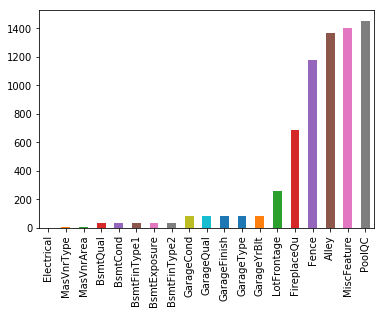

In [25]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

#El que tiene mayor cantidad de missing values es PoolQC

In [26]:
#missing values
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [27]:
#Datos de cada variable
train_CSV_File.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


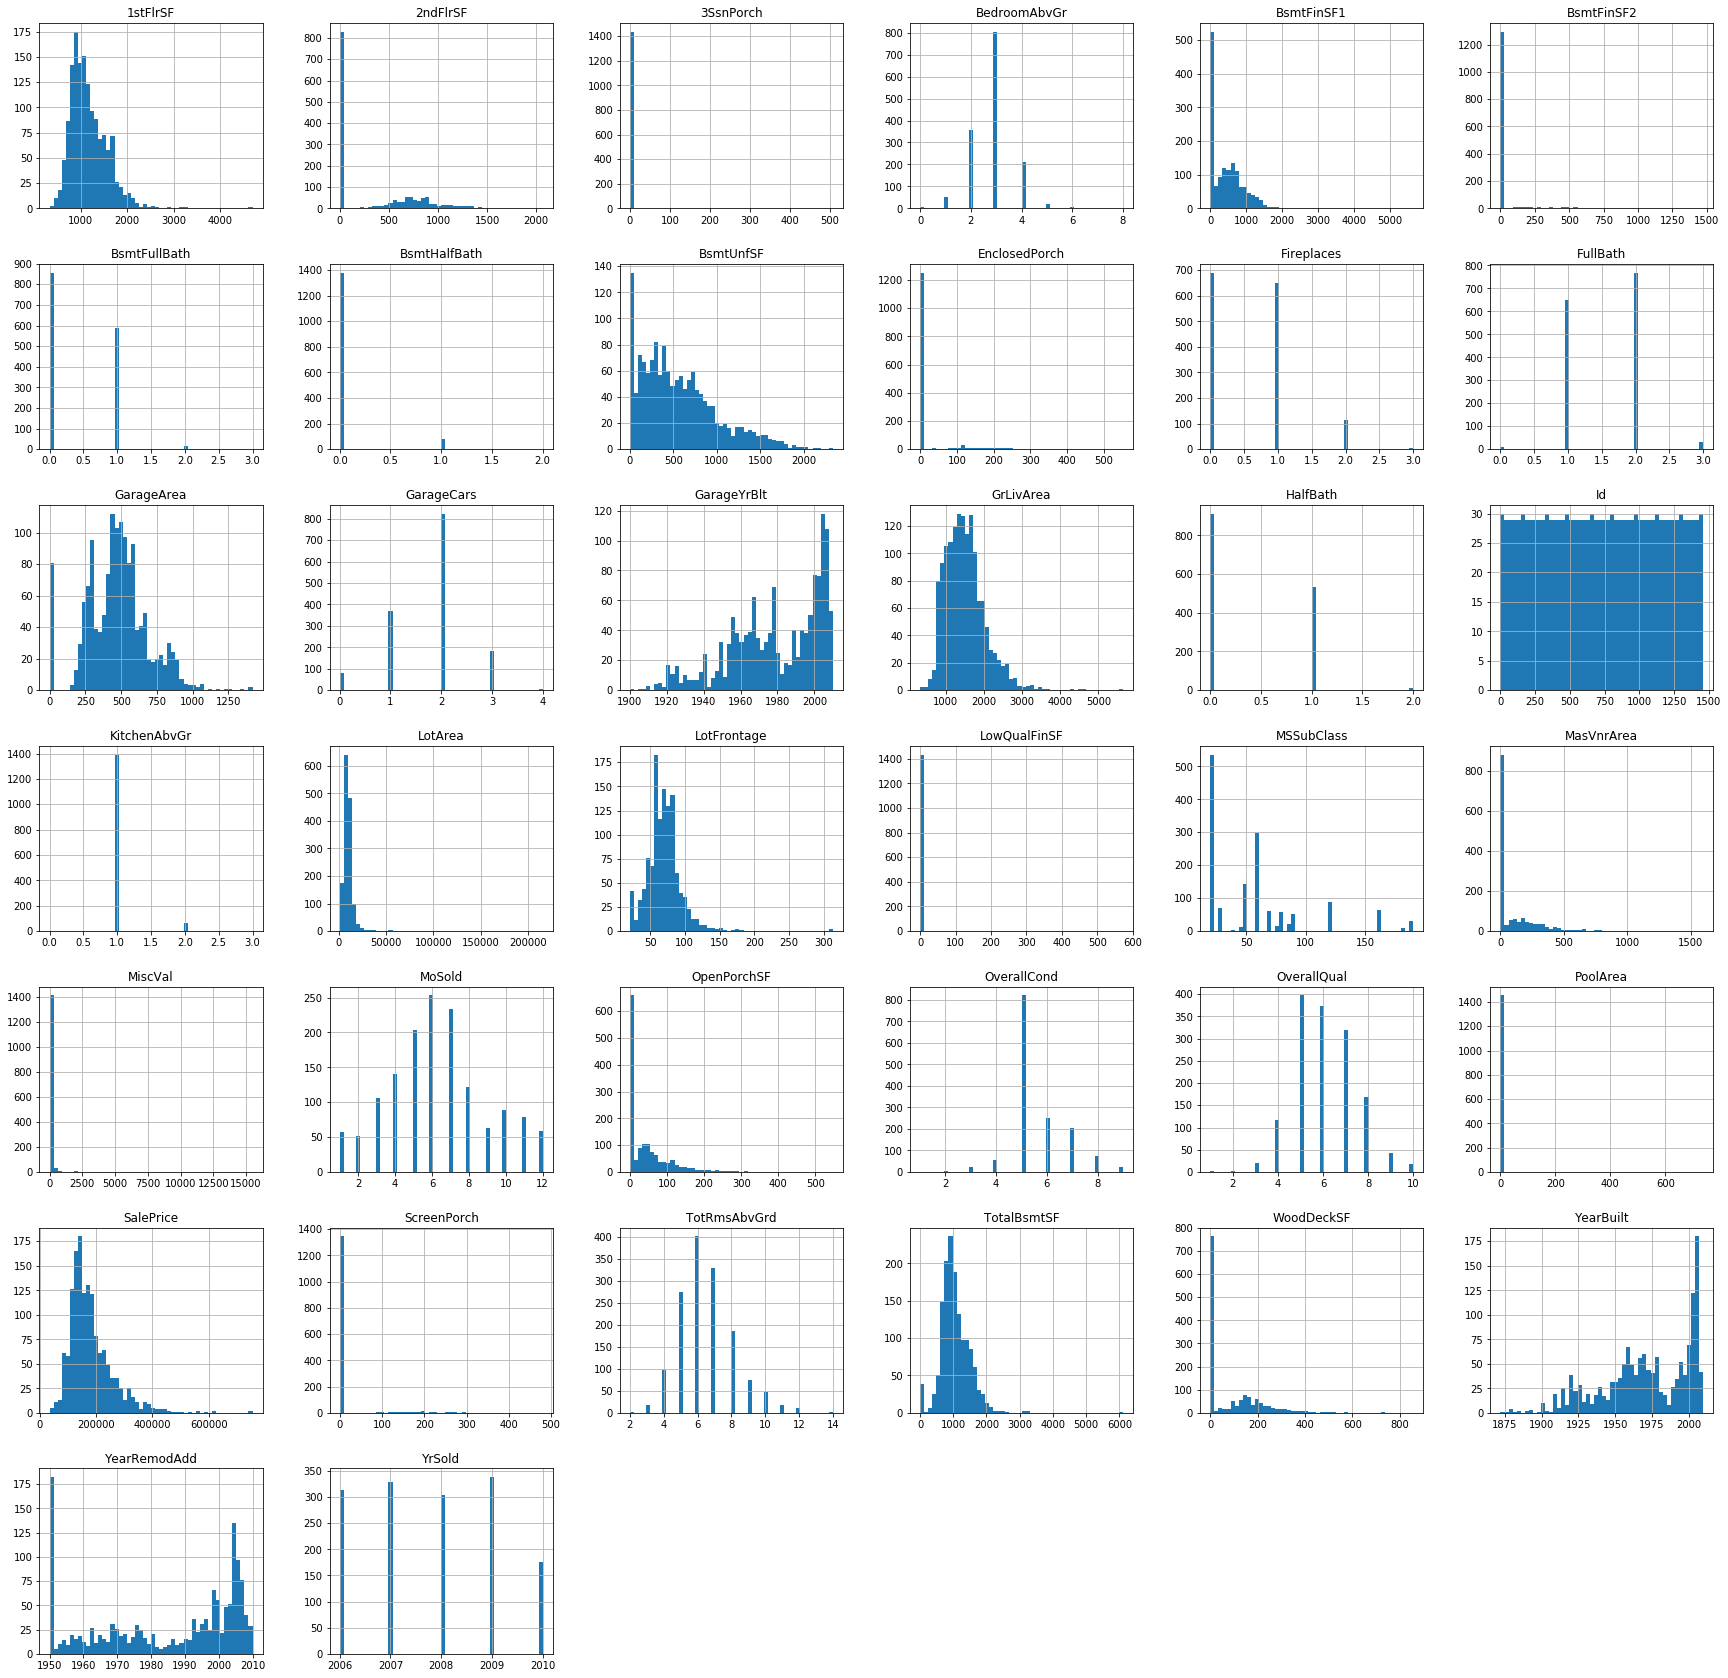

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
train_CSV_File.hist(bins=50, figsize=(30,30))
plt.show()

In [29]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())
#Ninguna variable cuantitativa tiene una distribución normal se deben transformar

False


In [30]:
#Variable a predecir
train_CSV_File['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\Users\Maria\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


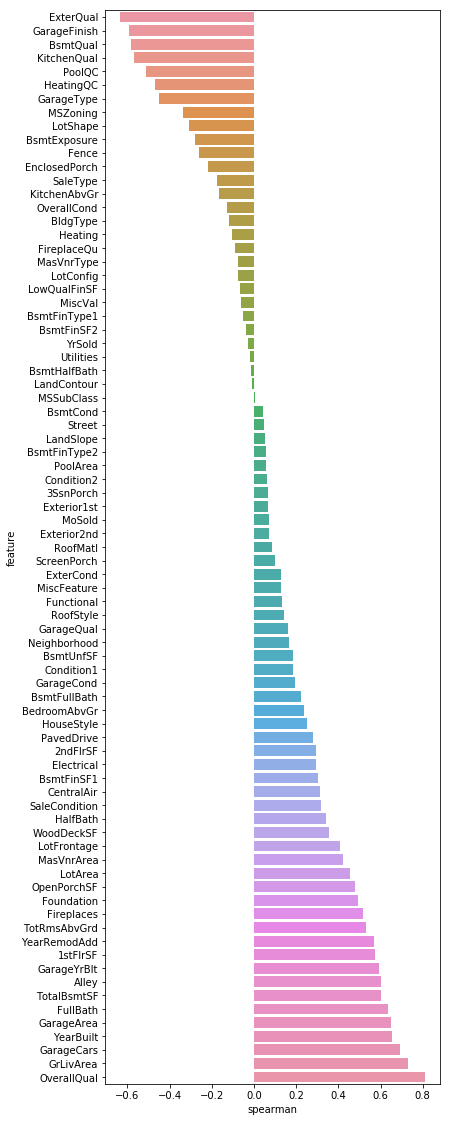

In [31]:
#Correlacion con la variable a predecir
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qualitative 
spearman(train, features)

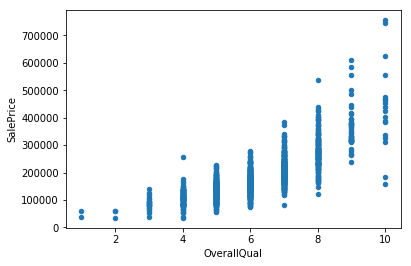

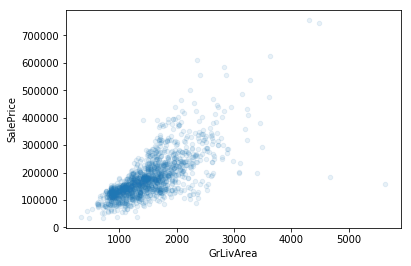

In [67]:
#Correlacion con OverallQual
train_CSV_File.plot(kind="scatter", x="OverallQual", y="SalePrice")
train_CSV_File.plot(kind="scatter", x="GrLivArea", y="SalePrice", alpha=0.1)

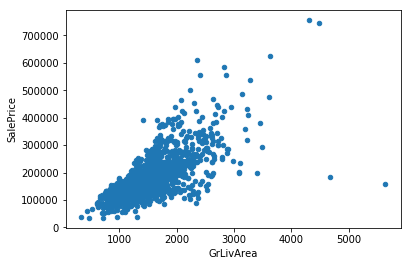

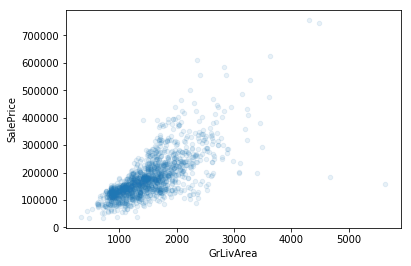

In [68]:
#Correlacion con GrLivArea
train_CSV_File.plot(kind="scatter", x="GrLivArea", y="SalePrice")
train_CSV_File.plot(kind="scatter", x="GrLivArea", y="SalePrice", alpha=0.1)

## 4) Prepare the data

In [39]:
housing = train_CSV_File.drop("SalePrice", axis=1) # drop labels for training set
housing_labels = train_CSV_File["SalePrice"].copy()
print("Exitoso: Se creo un train set (housing) sin SalePrice: ")

Exitoso: Se creo un train set (housing) sin SalePrice: 


In [41]:
!pip install -U -q sklearn-pandas
from sklearn.preprocessing import Imputer
import sklearn_pandas


In [52]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

for i in range(housing.shape[1]):
    if housing.iloc[:,i].dtypes == object:
        lbl = LabelEncoder() ## averiguar como funciona este o sino usar el one hot encoder
        lbl.fit(list(housing.iloc[:,i].values) )
        housing.iloc[:,i] = lbl.transform(list(housing.iloc[:,i].values))

In [53]:
housing_num = housing.select_dtypes(include=[np.number])

housing_cat = housing.select_dtypes(include=[np.object])

In [54]:
#Pipeline

from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


num_attribs = list(housing_num)
cat_attribs = list(housing_cat)

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),

    ])

C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [56]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [57]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.73086488,  0.07337496, -0.04553194, ...,  0.13877749,
         0.31386709,  0.2085023 ],
       [-1.7284922 , -0.87256276, -0.04553194, ..., -0.61443862,
         0.31386709,  0.2085023 ],
       [-1.72611953,  0.07337496, -0.04553194, ...,  0.13877749,
         0.31386709,  0.2085023 ],
       ...,
       [ 1.72611953,  0.30985939, -0.04553194, ...,  1.64520971,
         0.31386709,  0.2085023 ],
       [ 1.7284922 , -0.87256276, -0.04553194, ...,  1.64520971,
         0.31386709,  0.2085023 ],
       [ 1.73086488, -0.87256276, -0.04553194, ...,  0.13877749,
         0.31386709,  0.2085023 ]])

In [58]:
housing_prepared.shape

(1460, 80)

## 5) Explore different models

### a) Linear regression ( sklearn)

In [59]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [61]:
# Vemos las predicciones con algunos datos los primeros 10
some_data = housing.iloc[:10]
some_labels = housing_labels.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data) #Transformamos algunos daditos del dataset

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [216396.9148297  201075.82204505 219216.91561146 173186.73752955
 288093.54752887 168719.27486322 294211.71880264 235167.16711045
 159888.96308243 115375.07666694]


In [62]:
print("Labels:", list(some_labels))

Labels: [208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000]


In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

housing_predictions = lin_reg.predict(housing_prepared) #(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("RMSE de regresión lineal: ",lin_rmse)
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
print("El error absoluto es: ",lin_mae)

RMSE de regresión lineal:  30241.436774160844
El error absoluto es:  18533.340946443175


### b) DecisionTreeRegressor (sklearn)

In [113]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [114]:
housing_predictions = tree_reg.predict(housing_prepared)
#print(housing_labels)
#print(housing_predictions)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("RMSE de DecisionTreeRegressor es: ",tree_rmse)

RMSE de DecisionTreeRegressor es:  0.0


In [138]:
print(X_test_prepared.shape)
housing_predictions = tree_reg.predict(X_test_prepared)
test_ids = test_labels["Id"].copy()
print(len(test_ids))
print(len(housing_predictions))
#print(housing_predictions)
#print(test_ids)

(1459, 80)
1459
1459


In [139]:
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": housing_predictions
})
fileT = open("submission_test_tree.csv","w+")
#print(len(submission))
#print(submission.to_string(index=False).replace("      ",",").replace("  ",","))
fileT.write(submission.to_string(index=False).replace("      ",",").replace("  ",","))
fileT.close()

### a) Linear regression ( own implementation)

In [74]:
def predict(theta, data):
    return np.dot(data,theta)

In [70]:
def computeCost(X,y,theta):
    m = len(y)
    predictions= X.dot(theta)
    cost = (1/2*m)*np.sum(np.square(predictions-y))
    return cost

In [71]:
def gradientDescent( x, y,theta,  num_iters, alpha):
    m = len(y)
    cost = np.ones(num_iters)
    for i in range(num_iters):
        h= predict(theta, x )
        theta=  theta - (alpha/x.shape[0])*(x.T.dot((h-y)))
        cost[i] = computeCost(x,y,theta)
    return theta, cost    


In [92]:
alpha = 0.01
iters = 1500
theta = np.zeros(num_features+1)# inicializar con un vector de ceros. 
theta,cost = gradientDescent(housing_prepared, housing_labels,theta,iters,alpha)

In [93]:
print("Entrenamiento usando Gradiente Descendiente")
print("=========================================")
print("Vector Theta")
print(theta)
print(theta.shape)
print("X.shape")
print(housing_prepared.shape)

Entrenamiento usando Gradiente Descendiente
Vector Theta
[ -678.56226325 -5029.35405184  -698.86385293 -3523.71283886
  4173.30152231  1933.51026817  1936.64375664 -1338.01559721
  2300.80208754 -1401.53847348    21.82861266  1459.61350111
  2463.06041771  -891.54882409 -2459.37402973 -2843.64994499
 -1902.13421917 14981.73121363  5279.64233128  4882.0807638
   824.86029281  1689.79456223  3333.77767347 -3484.11781897
  1564.89164001  2746.66442564  5922.13786558 -6671.46972014
   669.29353505  1448.84283898 -7528.73789227  1736.42147637
 -4355.38143286 -1091.33520702  2407.33176097  1102.44519139
  1385.31374172 -1429.42531679  1572.44823487  -519.64899806
 -1554.63246249  -276.19804822  -505.7813462   8590.2028683
  7602.78869204  -935.03950487 12548.96711335  3449.87080918
  -132.65374496  2809.56962432   405.37857003 -2740.43284913
 -2739.26538195 -7146.88984713  6134.33758457  3945.76472682
  2169.10330697 -1589.79484681  1787.93503918 -1267.15143839
   -36.18377021  7754.39707365

Text(0.5, 1.0, 'Costo por iteración')

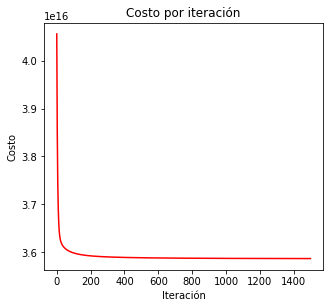

In [94]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10


#plot the cost
plt.subplot(2,1,1)
plt.plot(np.arange(iters), cost, 'r')  
plt.xlabel('Iteración')  
plt.ylabel('Costo')  
plt.title('Costo por iteración') # Esta gráfica es del costo en el conjunto de entrenamiento y debiera disminuir.


In [95]:
_predi = predict(theta,housing_prepared)
lin_mse = mean_squared_error(housing_labels, _predi)
lin_rmse = np.sqrt(lin_mse)
print("El error (RMSE) de nuestra regresión lineal es: ",lin_rmse)
#con 1500 iters: 183436.7409463473
#con 10000 iters: 183431.28244828494

El error (RMSE) de nuestra regresión lineal es:  183436.7409463473


In [96]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, _predi)
print("El error (absoluto) de nuestra regresión lineal es: ",lin_mae)
#con 1500 iters: 181404.7706507023
#con 10000 iters: 181394.00113204023

El error (absoluto) de nuestra regresión lineal es:  181404.7706507023


## 6) Fine-tune your model

In [97]:
X_test = test_CSV_File

X_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [98]:
from sklearn import preprocessing
for i in range(X_test.shape[1]):
    if X_test.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(X_test.iloc[:,i].values) )
        X_test.iloc[:,i] = lbl.transform(list(X_test.iloc[:,i].values))

In [99]:
X_test_prepared = full_pipeline.fit_transform(X_test)
X_test_prepared

array([[-1.73086406, -0.87471081, -1.49289614, ...,  1.71390537,
         0.32424468,  0.20138321],
       [-1.72848977, -0.87471081, -0.04659105, ...,  1.71390537,
         0.32424468,  0.20138321],
       [-1.72611547,  0.06135085, -0.04659105, ...,  1.71390537,
         0.32424468,  0.20138321],
       ...,
       [ 1.72611547, -0.87471081, -0.04659105, ..., -1.35995811,
         0.32424468, -3.58981811],
       [ 1.72848977,  0.64638939, -0.04659105, ..., -1.35995811,
         0.32424468,  0.20138321],
       [ 1.73086406,  0.06135085, -0.04659105, ..., -1.35995811,
         0.32424468,  0.20138321]])

In [102]:
test_y = test_labels["SalePrice"].copy()
test_ids = test_labels["Id"].copy()

parameters = {"max_depth": range(1,4), "random_state":range(1,10)}
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(tree_reg, param_grid=parameters, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels.ravel())
grid_search.best_params_

{'max_depth': 3, 'random_state': 1}

In [131]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(test_y, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

67142.26671013898
1459
1459


## 7) Present your solution

In [112]:
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": final_predictions
})
file1 = open("submission_test.csv","w+")
#print(len(submission))
#print(submission.to_string(index=False).replace("      ",",").replace("  ",","))
file1.write(submission.to_string(index=False).replace("      ",",").replace("  ",","))
file1.close()